In [10]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, Point

import warnings
warnings.filterwarnings('ignore')

# Iowa's approximate bounding box
# bbox = (43.5, 40.4, -90.1, -96.6)


graph_filepath = "../data/iowa.graphml"
towns_filepath = "../data/towns.pkl"
towns_cleaned_filepath = "../data/towns_cleaned.pkl"

### Load graph

In [11]:
G = ox.load_graphml(graph_filepath)

Alternatively, here is the code to download it from scratch

In [ ]:
# Download the road network data for Iowa
# G = ox.graph_from_place("Iowa", network_type="drive")

Save graph

In [ ]:
# ox.save_graphml(G, graph_filepath)

## Analysis

In [3]:
# gdf = ox.geocode_to_gdf("Iowa")

In [9]:
# fig, ax = ox.plot_graph(gdf, node_color="r")

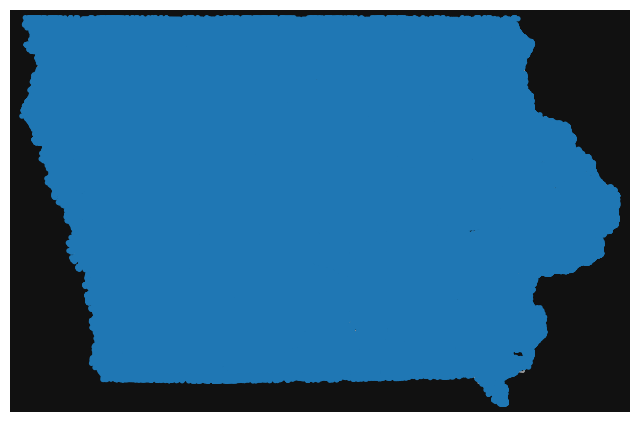

In [13]:
fig, ax = ox.plot_graph(G, node_color="tab:blue")

In [ ]:
nodes, edges = ox.graph_to_gdfs(G)

## Query Towns and Save
This takes a really long time to query the first time, but only 2 minutes the second.

In [13]:
# towns = ox.features_from_place('Iowa, USA', tags={'place': ['city', 'town', 'village']})
# towns = ox.features_from_place('Iowa, USA', tags={'place': ['city', 'town']})

# with open(towns_filepath, "wb") as f:
#     pickle.dump(towns, f)

Load towns from saved results

In [11]:
with open(towns_filepath, "rb") as f:
    towns = pickle.load(f)

### Clean up the towns data

In [7]:
# Keep only the useful columns
towns = towns.filter(['name', 'place', 'population', 'wikipedia', 'centroid', 'geometry'])

# Remove 'element_type',  'osmid' indexing 
towns = towns.reset_index()

In [14]:
towns['node'] = ox.nearest_nodes(G, towns.centroid.x, towns.centroid.y)
towns['lon'] = towns.centroid.x
towns['lat'] = towns.centroid.y

In [15]:
# town_coords = list(zip(towns.centroid.y, towns.centroid.x))

# # Function to find nearest node in the graph to a given point
# def get_nearest_node(point):
#     return ox.nearest_nodes(G, point[0], point[1])

# # Map town centroids to nearest graph nodes
# town_nodes = [get_nearest_node((lat, lon)) for lat, lon in town_coords]

In [23]:
type(towns), towns.shape, towns.columns

(geopandas.geodataframe.GeoDataFrame,
 (1817, 10),
 Index(['element_type', 'osmid', 'name', 'place', 'population', 'wikipedia',
        'geometry', 'node', 'lon', 'lat'],
       dtype='object'))

### Remove duplications
Some towns / cities are in the dataset twice, e.g. `towns[towns.name == 'Albia']` has a row for both element_type's node and relation

Create 'towns_unique' which contains one entry per town, preferring 'relation' over 'node'

In [90]:
# Define priority: lower number means higher priority
priority_mapping = {'relation': 1, 'node': 2}

# Add a priority column based on 'element_type'
towns['priority'] = towns['element_type'].map(priority_mapping)

# Sort the GeoDataFrame by 'name' and then by 'priority'
towns_sorted = towns.sort_values(['name', 'priority'])

# Drop duplicates based on 'name', keeping the first occurrence (highest priority)
towns_unique = towns_sorted.drop_duplicates(subset='name', keep='first')

# Merge towns_unique with the original towns to bring in additional information
merged_towns = towns_unique.merge(
    towns[['name', 'population', 'wikipedia']],
    on='name',
    how='left',
    suffixes=('', '_source')
)

# Update the population and wikipedia columns in towns_unique with non-NaN values from the source
merged_towns['population'] = merged_towns['population'].combine_first(merged_towns['population_source'])
merged_towns['wikipedia'] = merged_towns['wikipedia'].combine_first(merged_towns['wikipedia_source'])

# Drop the extra columns used for merging
merged_towns = merged_towns.drop(columns=['population_source', 'wikipedia_source'])

# Sort by 'name' and 'priority' again to ensure correct deduplication
merged_towns = merged_towns.sort_values(['name', 'priority'])

# Drop duplicates based on 'name', keeping the first occurrence (highest priority)
towns_unique = merged_towns.drop_duplicates(subset='name', keep='first')
towns_unique = towns_unique.drop(columns='priority')
towns_unique = towns_unique.reset_index(drop=True)

### Get wiki information

In [92]:
import wptools
import re

# Helper function to extract just the County name. E.g. '[[Warren County, Iowa|Warren]]' -> 'Warren'
def extract_county(county_string):
    if isinstance(county_string, str):
        match = re.search(r'\[\[.*?\|(.+?)\]\]', county_string)
        if match:
            return match.group(1)
        return county_string.strip()  # Return the original string if no match
    return None  # Handle cases where the input is not a string

# Define a function to extract population and county from a Wikipedia page
def get_population_and_county(page_title):
    try:
        # Fetch the page
        page = wptools.page(page_title, silent=True)
        page.get_parse()
        infobox = page.data.get('infobox', {})

        # Extract population
        population = infobox.get('population_total') or infobox.get('population') or None
        if population:
            population = population.replace(',', '').strip()
            try:
                population = int(population)
            except ValueError:
                population = None

        # Extract county
        county = None
        for i in range(1, 10):  # Check multiple subdivision levels
            stype = infobox.get(f'subdivision_type{i}')
            sname = infobox.get(f'subdivision_name{i}')
            if stype and 'county' in stype.lower():
                county = sname
                break
        if not county:
            county = infobox.get('county')

        return population, county
    except Exception as e:
        print(f"Error processing page {page_title}: {e}")
        return None, None
    

def add_wiki_data(towns):
    towns['population_wiki'] = None
    towns['county_wiki'] = None

    # Iterate over the DataFrame rows
    for index, row in towns.iterrows():
        page_title = row['wikipedia']
        if isinstance(page_title, str):
            # Remove 'en:' prefix if present
            if page_title.startswith('en:'):
                page_title = page_title[3:]
            page_title = page_title.strip()

            # Get population and county
            population, county = get_population_and_county(page_title)

            # Assign the values back to the DataFrame
            towns.at[index, 'population_wiki'] = population
            towns.at[index, 'county_wiki'] = extract_county(county)
        else:
            towns.at[index, 'population_wiki'] = None
            towns.at[index, 'county_wiki'] = None

    return towns

towns_unique = add_wiki_data(towns_unique)
# population, county = get_population_and_county('en:Ackworth, Iowa')

Error processing page Bonaparte, Iowa: (28, 'Failed to connect to en.wikipedia.org port 443 after 75001 ms: Could not connect to server')


In [61]:
towns_unique[towns_unique.population.isna()]

,element_type,osmid,name,place,population,wikipedia,geometry,node,lon,lat,priority,population_wiki,county_wiki
33,relation,128667,Aredale,city,NaN,"en:Aredale, Iowa","POLYGON ((-93.01537 42.84045, -92.99558 42.840...",159143346,-93.005497,42.833197,1.0,62,Butler
34,node,151479000,Argyle,village,NaN,NaN,POINT (-91.56648 40.53258),160291964,-91.566481,40.532581,2.0,None,None
36,relation,128395,Arispe,city,NaN,"en:Arispe, Iowa","POLYGON ((-94.23090 40.95239, -94.21447 40.952...",161201110,-94.220825,40.948518,1.0,96,Union
43,relation,129149,Aspinwall,city,NaN,"en:Aspinwall, Iowa","POLYGON ((-95.14124 41.91418, -95.13146 41.914...",159514298,-95.136388,41.910556,1.0,33,Crawford
56,relation,128811,Balltown,city,NaN,"en:Balltown, Iowa","POLYGON ((-90.87308 42.63426, -90.87333 42.634...",159590642,-90.869806,42.637294,1.0,79,Dubuque
...,...,...,...,...,...,...,...,...,...,...,...,...,...
958,relation,128675,Willey,city,NaN,"en:Willey, Iowa","POLYGON ((-94.82723 41.98239, -94.81750 41.982...",159191722,-94.822383,41.978783,1.0,73,Carroll
976,relation,129207,Yetter,city,NaN,"en:Yetter, Iowa","POLYGON ((-94.84808 42.31804, -94.84314 42.317...",159202130,-94.843174,42.316119,1.0,19,Calhoun
977,relation,129283,Yorktown,city,NaN,"en:Yorktown, Iowa","POLYGON ((-95.15915 40.73906, -95.15755 40.739...",160683980,-95.154365,40.735301,1.0,60,Page
979,node,151535558,Zero,village,NaN,NaN,POINT (-93.12715 40.98334),160316134,-93.127149,40.983336,2.0,None,None


In [44]:
towns_unique[towns_unique.wikipedia.isna()]

,element_type,osmid,name,place,population,wikipedia,geometry,node,lon,lat,priority
34,node,151479000,Argyle,village,NaN,NaN,POINT (-91.56648 40.53258),160291964,-91.566481,40.532581,2.0
109,node,151599869,Brooks,village,NaN,NaN,POINT (-94.80498 40.96526),158935408,-94.804976,40.965265,2.0
116,node,151601418,Burr Oak,village,171,NaN,POINT (-91.86565 43.45685),161333482,-91.865646,43.456853,2.0
159,node,9445173132,Clarksville,village,1264,NaN,POINT (-92.66798 42.78456),159141123,-92.667976,42.784555,2.0
547,node,151408623,Marquisville,village,NaN,NaN,POINT (-93.60083 41.65333),160926944,-93.600835,41.653331,2.0
647,node,151712467,Norwoodville,village,NaN,NaN,POINT (-93.56105 41.64388),160940573,-93.561049,41.643878,2.0
787,node,9664667973,Saint Lucas,village,167,NaN,POINT (-91.93253 43.06669),4909911980,-91.932528,43.066694,2.0
794,node,151865769,Saylor,village,NaN,NaN,POINT (-93.62017 41.66456),160754748,-93.620170,41.664557,2.0
947,way,287891920,Western,village,NaN,NaN,"POLYGON ((-91.65131 41.86640, -91.65129 41.865...",160356251,-91.644591,41.864421,NaN
979,node,151535558,Zero,village,NaN,NaN,POINT (-93.12715 40.98334),160316134,-93.127149,40.983336,2.0


In [109]:
# manual_wikipedia_data = {
#     523: 'en:Orange City, Iowa', 
#     649: 'en:Sioux City, Iowa',
#     676: 'en:Story City, Iowa',
# }
# for index, wiki in manual_wikipedia_data.items():
#     towns_unique.at[index, 'wikipedia'] = wiki

# manual_population_data = {
#     523: 6397,  # Add the population for Orange
#     649: 85727,  # Add the population for Sioux City
#     676: 3396,  # Add the population for Story City
# }
# for index, population in manual_population_data.items():
#     towns_unique.at[index, 'population_wiki'] = population

Cast to int

In [93]:
towns_unique.population = towns_unique.population.astype("Int64")
towns_unique.population_wiki = towns_unique.population_wiki.astype("Int64")

In [72]:
# towns_unique[(~towns_unique.population.isna()) & (towns_unique.population_wiki.isna())]

In [73]:
# towns_unique[(~towns_unique.population.isna()) & (towns_unique.population != towns_unique.population_wiki)]

Fill any rows where we have 'population' from OSM, but not from wikipedia. Then, keep that as the final population number.

In [94]:
# merged_towns['population'] = merged_towns['population'].combine_first(merged_towns['population_source'])
# towns_unique['population'].combine_first(towns_unique['population_wiki'])
towns_unique['population'] = towns_unique['population_wiki'].combine_first(towns_unique['population'])
towns_unique = towns_unique.drop(columns=['population_wiki'])

In [95]:
towns_unique = towns_unique.rename(columns={'county_wiki': 'county'})

We still have a handful of villages without populations. I wasn't able to find these in census data either so I'm just going to drop them.

In [96]:
towns_unique[(towns_unique.population.isna())]

,element_type,osmid,name,place,population,wikipedia,geometry,node,lon,lat,county
34,node,151479000,Argyle,village,<NA>,NaN,POINT (-91.56648 40.53258),160291964,-91.566481,40.532581,None
109,node,151599869,Brooks,village,<NA>,NaN,POINT (-94.80498 40.96526),158935408,-94.804976,40.965265,None
306,node,151321742,Florenceville,village,<NA>,"en:Florenceville, Iowa",POINT (-92.13266 43.49913),159920594,-92.132664,43.499133,Howard
547,node,151408623,Marquisville,village,<NA>,NaN,POINT (-93.60083 41.65333),160926944,-93.600835,41.653331,None
647,node,151712467,Norwoodville,village,<NA>,NaN,POINT (-93.56105 41.64388),160940573,-93.561049,41.643878,None
794,node,151865769,Saylor,village,<NA>,NaN,POINT (-93.62017 41.66456),160754748,-93.620170,41.664557,None
947,way,287891920,Western,village,<NA>,NaN,"POLYGON ((-91.65131 41.86640, -91.65129 41.865...",160356251,-91.644591,41.864421,None
979,node,151535558,Zero,village,<NA>,NaN,POINT (-93.12715 40.98334),160316134,-93.127149,40.983336,None


In [97]:
towns_unique = towns_unique.dropna(subset='population')

Some other towns were included in the dataset, e.g. 'en:Bellevue, Nebraska'

This keeps towns_unique to only have Iowa towns.

In [98]:
towns_unique[towns_unique["wikipedia"].str.contains('Iowa') == False]

,element_type,osmid,name,place,population,wikipedia,geometry,node,lon,lat,county
81,relation,137415,Bigelow,city,227,"en:Bigelow, Minnesota","POLYGON ((-95.68396 43.51076, -95.68411 43.500...",1861003340,-95.689145,43.505367,Nobles
125,relation,195181,Canton,city,3066,"en:Canton, South Dakota","POLYGON ((-96.62290 43.30096, -96.62289 43.302...",160353034,-96.585070,43.303139,Lincoln
209,relation,127060,Dallas City,city,805,"en:Dallas City, Illinois","POLYGON ((-91.14618 40.64570, -91.14620 40.645...",160289711,-91.164467,40.635279,None
266,relation,137401,Eitzen,city,279,"en:Eitzen, Minnesota","POLYGON ((-91.46144 43.51245, -91.46145 43.511...",158907038,-91.463634,43.508110,Houston
281,relation,137291,Elmore,city,549,"en:Elmore, Minnesota","POLYGON ((-94.09804 43.51087, -94.09306 43.510...",160301063,-94.088256,43.506302,Faribault
285,relation,137587,Emmons,city,367,"en:Emmons, Minnesota","POLYGON ((-93.48880 43.49960, -93.49863 43.499...",1863865594,-93.485096,43.507046,Freeborn
296,relation,195182,Fairview,town,61,"en:Fairview, South Dakota","POLYGON ((-96.49165 43.22333, -96.49106 43.223...",161008375,-96.487561,43.222283,Lincoln
372,relation,123527,Hamilton,city,2753,"en:Hamilton, Illinois","POLYGON ((-91.42197 40.37588, -91.42041 40.378...",1837376049,-91.362781,40.389920,Hancock
437,relation,125912,Keithsburg,city,550,"en:Keithsburg, Illinois","POLYGON ((-90.94261 41.10959, -90.94264 41.108...",160371036,-90.935334,41.100337,Mercer
521,relation,137795,Lyle,city,522,"en:Lyle, Minnesota","POLYGON ((-92.94968 43.51299, -92.94970 43.514...",160494352,-92.941285,43.505833,Mower


In [104]:
towns_unique = towns_unique[towns_unique["wikipedia"].str.contains('Iowa') == True].copy()

In [107]:
towns_unique['centroid'] = towns_unique.geometry.centroid
towns_unique.head()

,element_type,osmid,name,place,population,wikipedia,geometry,node,lon,lat,county,centroid
0,relation,128725,Ackley,village,1599,"en:Ackley, Iowa","POLYGON ((-93.05636 42.56577, -93.05635 42.564...",159829726,-93.052395,42.551887,None,POINT (-93.05239 42.55189)
1,relation,128768,Ackworth,city,115,"en:Ackworth, Iowa","POLYGON ((-93.47793 41.37143, -93.46665 41.371...",161229705,-93.472587,41.366182,Warren,POINT (-93.47259 41.36618)
2,relation,128953,Adair,village,791,"en:Adair, Iowa","POLYGON ((-94.65790 41.51116, -94.64338 41.511...",158871434,-94.643431,41.500389,None,POINT (-94.64343 41.50039)
3,relation,129250,Adel,town,6153,"en:Adel, Iowa","POLYGON ((-94.01198 41.61467, -94.01209 41.615...",159443403,-94.011820,41.610125,Dallas,POINT (-94.01182 41.61012)
4,relation,128396,Afton,village,874,"en:Afton, Iowa","POLYGON ((-94.20276 41.03727, -94.20218 41.036...",161211383,-94.195194,41.027677,Union,POINT (-94.19519 41.02768)


Save towns_unique

In [108]:
with open(towns_cleaned_filepath, "wb") as f:
    pickle.dump(towns_unique, f)

## Old analysis

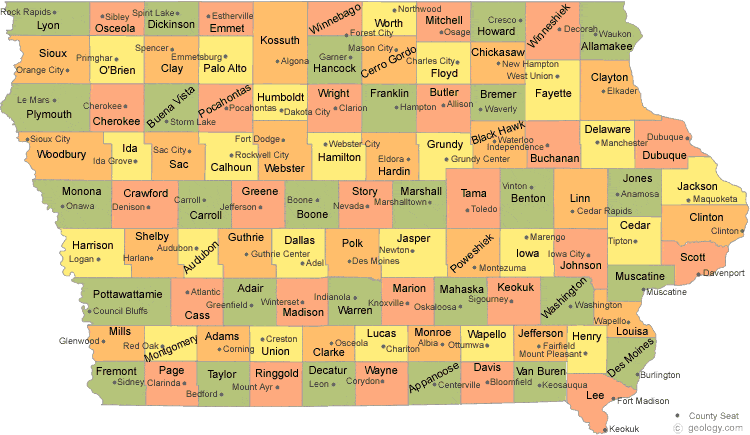

In [40]:
start_counties = ['Lyon', 'Sioux', 'Plymouth', 'Woodbury', 'Monana', 'Harrison', 'Pottawattamie', 'Mills', 'Fremont']
end_counties = ['Allamakee', 'Clayon', 'Dubuque', 'Jackson', 'Clinton', 'Scott', 'Muscatine', 'Louisa', 'Des Moines', 'Lee']

In [116]:
starting_towns = pd.read_clipboard()
starting_towns

,Starting Town,count
0,Sioux City,8
1,Council Bluffs,7
2,Glenwood,7
3,Onawa,6
4,Missouri Valley,4
5,Sioux Center,4
6,Hawarden,3
7,Rock Rapids,3
8,Le Mars,2
9,Sergeant Bluff,2


Sadly, Akron is missing from the towns dataset :(

but each of the starting towns has been over 1000 population

In [117]:
starting_towns = starting_towns.merge(towns_unique, how='left', left_on='Starting Town', right_on='name')
starting_towns

,Starting Town,count,element_type,osmid,name,place,population,wikipedia,geometry,county,centroid
0,Sioux City,8,relation,128576.0,Sioux City,city,85727,"en:Sioux City, Iowa","POLYGON ((-96.49899 42.56104, -96.49897 42.561...",None,POINT (-96.38977 42.49488)
1,Council Bluffs,7,relation,128357.0,Council Bluffs,city,62799,"en:Council Bluffs, Iowa","POLYGON ((-95.92094 41.18818, -95.92112 41.188...",Pottawattamie,POINT (-95.85158 41.23686)
2,Glenwood,7,relation,128856.0,Glenwood,town,5073,"en:Glenwood, Iowa","POLYGON ((-95.72313 41.03115, -95.72480 41.031...",Mills,POINT (-95.74041 41.04458)
3,Onawa,6,relation,128488.0,Onawa,town,2906,"en:Onawa, Iowa","POLYGON ((-96.10019 41.99783, -96.10217 41.997...",Monona,POINT (-96.09099 42.02642)
4,Missouri Valley,4,node,151845824.0,Missouri Valley,town,2678,"en:Missouri Valley, Iowa",POINT (-95.88794 41.55650),Harrison,POINT (-95.88794 41.55650)
5,Sioux Center,4,relation,129112.0,Sioux Center,town,8229,"en:Sioux Center, Iowa","POLYGON ((-96.16534 43.04430, -96.17523 43.044...",Sioux,POINT (-96.17084 43.07496)
6,Hawarden,3,node,151564254.0,Hawarden,town,2700,"en:Hawarden, Iowa",POINT (-96.48532 42.99566),Sioux,POINT (-96.48532 42.99566)
7,Rock Rapids,3,relation,128738.0,Rock Rapids,town,2611,"en:Rock Rapids, Iowa","POLYGON ((-96.18534 43.44029, -96.17551 43.440...",Lyon,POINT (-96.16623 43.42727)
8,Le Mars,2,relation,128375.0,Le Mars,town,10571,"en:Le Mars, Iowa","POLYGON ((-96.19793 42.74973, -96.20130 42.749...",Plymouth,POINT (-96.17351 42.78107)
9,Sergeant Bluff,2,node,151395884.0,Sergeant Bluff,town,5015,"en:Sergeant Bluff, Iowa",POINT (-96.35898 42.40392),Woodbury,POINT (-96.35898 42.40392)


In [72]:
states_shp_filepath = "./data/ne_110m_admin_1_states_provinces/ne_110m_admin_1_states_provinces.shp"
states_map = gpd.read_file(states_shp_filepath)
iowa_map = states_map[states_map.name == 'Iowa']

In [121]:
starting_towns_gdf = gpd.GeoDataFrame(starting_towns, geometry=starting_towns.geometry)
starting_towns_gdf.set_crs(epsg=4326, inplace=True)

,Starting Town,count,element_type,osmid,name,place,population,wikipedia,geometry,county,centroid
0,Sioux City,8,relation,128576.0,Sioux City,city,85727,"en:Sioux City, Iowa","POLYGON ((-96.49899 42.56104, -96.49897 42.561...",None,POINT (-96.38977 42.49488)
1,Council Bluffs,7,relation,128357.0,Council Bluffs,city,62799,"en:Council Bluffs, Iowa","POLYGON ((-95.92094 41.18818, -95.92112 41.188...",Pottawattamie,POINT (-95.85158 41.23686)
2,Glenwood,7,relation,128856.0,Glenwood,town,5073,"en:Glenwood, Iowa","POLYGON ((-95.72313 41.03115, -95.72480 41.031...",Mills,POINT (-95.74041 41.04458)
3,Onawa,6,relation,128488.0,Onawa,town,2906,"en:Onawa, Iowa","POLYGON ((-96.10019 41.99783, -96.10217 41.997...",Monona,POINT (-96.09099 42.02642)
4,Missouri Valley,4,node,151845824.0,Missouri Valley,town,2678,"en:Missouri Valley, Iowa",POINT (-95.88794 41.55650),Harrison,POINT (-95.88794 41.55650)
5,Sioux Center,4,relation,129112.0,Sioux Center,town,8229,"en:Sioux Center, Iowa","POLYGON ((-96.16534 43.04430, -96.17523 43.044...",Sioux,POINT (-96.17084 43.07496)
6,Hawarden,3,node,151564254.0,Hawarden,town,2700,"en:Hawarden, Iowa",POINT (-96.48532 42.99566),Sioux,POINT (-96.48532 42.99566)
7,Rock Rapids,3,relation,128738.0,Rock Rapids,town,2611,"en:Rock Rapids, Iowa","POLYGON ((-96.18534 43.44029, -96.17551 43.440...",Lyon,POINT (-96.16623 43.42727)
8,Le Mars,2,relation,128375.0,Le Mars,town,10571,"en:Le Mars, Iowa","POLYGON ((-96.19793 42.74973, -96.20130 42.749...",Plymouth,POINT (-96.17351 42.78107)
9,Sergeant Bluff,2,node,151395884.0,Sergeant Bluff,town,5015,"en:Sergeant Bluff, Iowa",POINT (-96.35898 42.40392),Woodbury,POINT (-96.35898 42.40392)


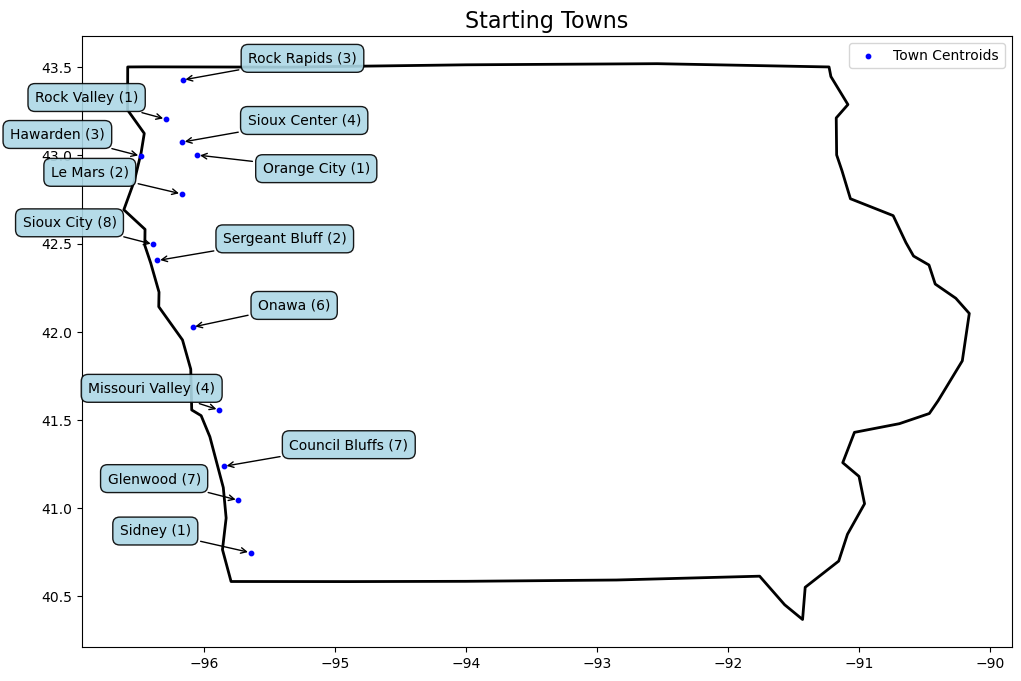

In [147]:
fig, ax = plt.subplots(figsize=(12, 8))
iowa_map.plot(ax=ax, color='none', edgecolor='black', linewidth=2, label='Iowa State Border')
starting_towns_gdf['centroid'].plot(ax=ax, color='blue', marker='o', markersize=10, label='Town Centroids')

i = 0
for x, y, label, count in zip(starting_towns_gdf['centroid'].x, starting_towns_gdf['centroid'].y, starting_towns_gdf['name'], starting_towns_gdf['count']):
    i += 1
    if i%2 == 0:
        x_offset = 0.5
    else:
        x_offset = -1
    if label == 'Orange City':
        y_offset = -1
    else: 
        y_offset = 1
    # Add label with arrow pointing to the centroid
    ax.annotate(
        text=str(label) + ' (' + str(count) + ')',
        xy=(x, y),  # Centroid coordinates
        xytext=(x + x_offset, y + 0.1 * y_offset),  # Offset for the label
        fontsize=10,
        bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5', alpha=0.9),
        arrowprops=dict(facecolor='black', arrowstyle='->', lw=1)
    )

plt.title("Starting Towns", fontsize=16)
plt.legend()
plt.show()

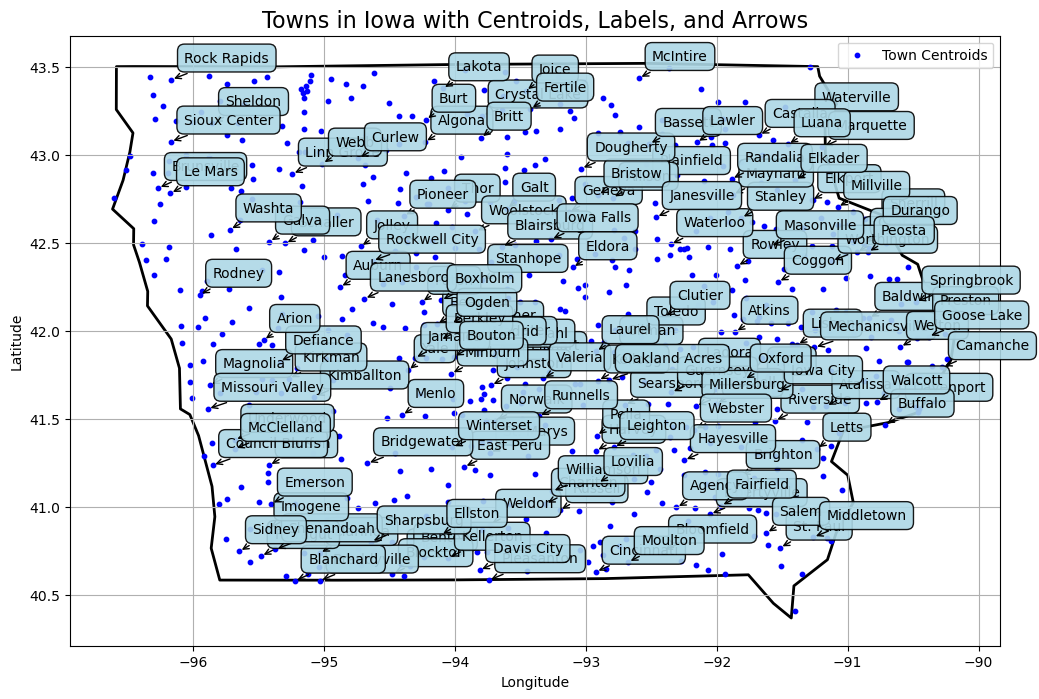

In [115]:
# Plot the Iowa map and the centroids of the towns
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the Iowa state border
iowa_map.plot(ax=ax, color='none', edgecolor='black', linewidth=2, label='Iowa State Border')

# Plot the centroids of the towns
towns_unique['centroid'].plot(ax=ax, color='blue', marker='o', markersize=10, label='Town Centroids')

# Randomly sample the towns for labeling
sampled_towns = towns_unique.sample(frac=0.21, random_state=42)

# Annotate only the sampled centroids with arrows
for x, y, label in zip(sampled_towns['centroid'].x, sampled_towns['centroid'].y, sampled_towns['name']):
    # Add label with arrow pointing to the centroid
    ax.annotate(
        text=label,
        xy=(x, y),  # Centroid coordinates
        xytext=(x + 0.1, y + 0.1),  # Offset for the label
        fontsize=10,
        bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5', alpha=0.9),
        arrowprops=dict(facecolor='black', arrowstyle='->', lw=1)
    )

plt.title("Towns in Iowa as Centroids", fontsize=16)
plt.legend()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

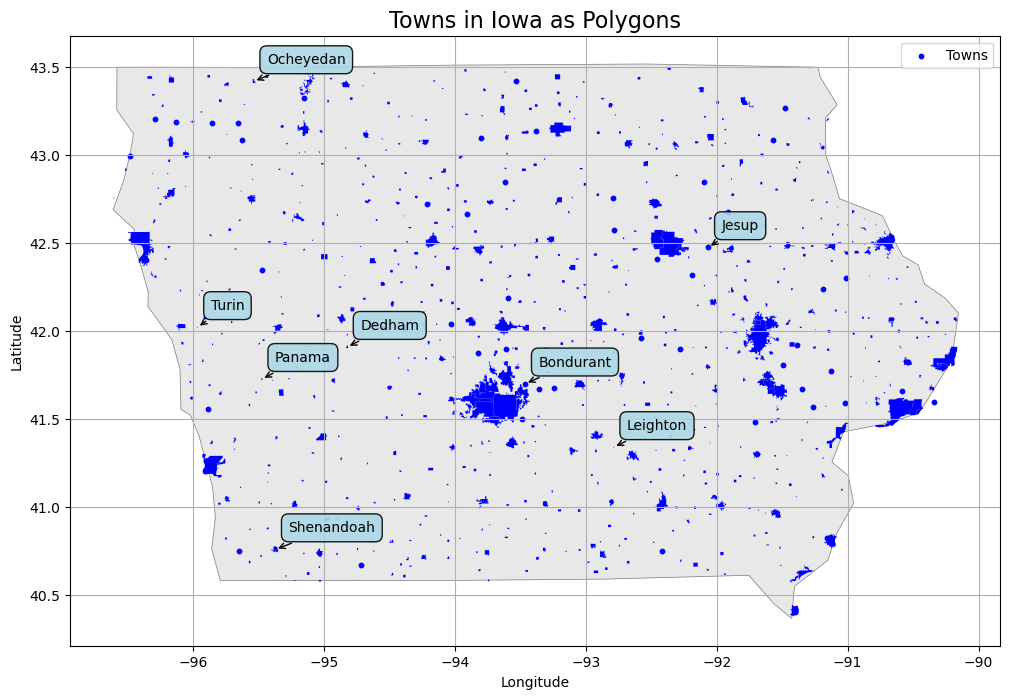

In [126]:

# iowa_shp_filepath = "./data/tl_2021_19_place/tl_2021_19_place.shp"
# iowa_map = gpd.read_file(iowa_shp_filepath)

fig, ax = plt.subplots(figsize=(12, 8))
iowa_map.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5, linewidth=0.5)


# Plot the towns on the map
towns_unique.plot(ax=ax, marker='o', color='blue', markersize=10, label='Towns')
# towns_unique['centroid'].plot(ax=ax, color='blue', marker='o', markersize=10, label='Town Centroids')

# Annotate the towns with their names
# for x, y, label in zip(towns_unique.geometry.x, towns_unique.geometry.y, towns_unique['name']):
#     plt.text(x, y, label, fontsize=8, ha='right')

# Randomly sample rows for labeling
sampled_towns = towns_unique.sample(frac=0.01, random_state=2)  # Set random_state for reproducibility
for x, y, label in zip(sampled_towns['centroid'].x, sampled_towns['centroid'].y, sampled_towns['name']):
    # Add label with arrow pointing to the centroid
    ax.annotate(
        text=label,
        xy=(x, y),  # Centroid coordinates
        xytext=(x + 0.1, y + 0.1),  # Offset for the label
        fontsize=10,
        bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5', alpha=0.9),
        arrowprops=dict(facecolor='black', arrowstyle='->', lw=1)
    )


# for x, y, label in zip(towns_unique['centroid'].x, towns_unique['centroid'].y, towns_unique['name']):
#     plt.text(x, y, label, fontsize=8, ha='right')

plt.title("Towns in Iowa as Polygons", fontsize=16)
plt.legend()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

Possible Starting towns:
- Carter Lake hasn't been chosen before, but it's basically Council Bluffs
- Hull is close to Souix Center and Rock Valley, but it's possible. Unlikely though 
- Logan is competing with Misourri Valley 

In [150]:
towns_unique[(towns_unique.county.isin(start_counties)) & (towns_unique.population > 1000)]

,element_type,osmid,name,place,population,wikipedia,geometry,county,centroid
101,relation,128356,Carter Lake,city,3791,"en:Carter Lake, Iowa","POLYGON ((-95.93008 41.28500, -95.93008 41.292...",Pottawattamie,POINT (-95.91755 41.28850)
151,relation,128357,Council Bluffs,city,62799,"en:Council Bluffs, Iowa","POLYGON ((-95.92094 41.18818, -95.92112 41.188...",Pottawattamie,POINT (-95.85158 41.23686)
269,relation,128856,Glenwood,town,5073,"en:Glenwood, Iowa","POLYGON ((-95.72313 41.03115, -95.72480 41.031...",Mills,POINT (-95.74041 41.04458)
309,node,151564254,Hawarden,town,2700,"en:Hawarden, Iowa",POINT (-96.48532 42.99566),Sioux,POINT (-96.48532 42.99566)
324,node,151389602,Hull,town,2384,"en:Hull, Iowa",POINT (-96.13388 43.18976),Sioux,POINT (-96.13388 43.18976)
377,relation,128375,Le Mars,town,10571,"en:Le Mars, Iowa","POLYGON ((-96.19793 42.74973, -96.20130 42.749...",Plymouth,POINT (-96.17351 42.78107)
398,relation,128471,Logan,town,1397,"en:Logan, Iowa","MULTIPOLYGON (((-95.80208 41.64982, -95.79113 ...",Harrison,POINT (-95.79118 41.64531)
461,node,151845824,Missouri Valley,town,2678,"en:Missouri Valley, Iowa",POINT (-95.88794 41.55650),Harrison,POINT (-95.88794 41.55650)
524,relation,128387,Orange City,town,6267,"en:Orange City, Iowa","POLYGON ((-96.05609 42.98213, -96.05803 42.982...",Sioux,POINT (-96.05524 43.00185)
606,relation,128738,Rock Rapids,town,2611,"en:Rock Rapids, Iowa","POLYGON ((-96.18534 43.44029, -96.17551 43.440...",Lyon,POINT (-96.16623 43.42727)
